In [1]:
# Import Tensorflow 2.0
%tensorflow_version 2.x
import tensorflow as tf 

# Download and import the MIT 6.S191 package
!pip install mitdeeplearning
import mitdeeplearning as mdl

# Import all remaining packages
import numpy as np
import os
import time
import functools
from IPython import display as ipythondisplay
from tqdm import tqdm
!apt-get install abcmidi timidity > /dev/null 2>&1

# Check that we are using a GPU, if not switch runtimes
#   using Runtime > Change Runtime Type > GPU
assert len(tf.config.list_physical_devices('GPU')) > 0

     |████████████████████████████████| 2.1MB 2.8MB/s 
  Created wheel for mitdeeplearning: filename=mitdeeplearning-0.1.2-cp36-none-any.whl size=2114585 sha256=af6c7ff361b4691b854e01061a87f939cd159fc5acba755e8de28c8e42b18c16
  Stored in directory: /root/.cache/pip/wheels/27/e1/73/5f01c787621d8a3c857f59876c79e304b9b64db9ff5bd61b74
Successfully built mitdeeplearning


In [2]:
!pip install mitdeeplearning
import mitdeeplearning as mdl

In [3]:
tf.config.get_visible_devices()
!nvidia-smi

Sat Oct 17 13:49:40 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P8    32W / 149W |     11MiB / 11441MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
# Download the dataset
songs = mdl.lab1.load_training_data()
# Print one of the songs to inspect it in greater detail!
example_song = songs[np.random.randint(len(songs))]
print("\nExample song: ")
print(example_song)

Found 816 songs in text

Example song: 
X:17
T:Martin's Favourite
Z: id:dc-slide-37
M:6/8
L:1/8
K:G Major
d|g2d e2d|g2d e2d|BdB ABA|G2A BGE|!
D2E G2A|B2d dBG|BdB ABA|G3 G2:|!
E|D2E G2A|B2d dBG|BdB ABA|G2A BGE|!
D2E G2A|B2d dBG|BdB ABA|G3 G2:|!


In [5]:
# Join our list of song strings into a single string containing all songs
songs_joined = "\n\n".join(songs) 

# Find all unique characters in the joined string
vocab = sorted(set(songs_joined))
print("There are", len(vocab), "unique characters in the dataset")

There are 83 unique characters in the dataset


In [6]:
### Define numerical representation of text ###
idx2char = np.array(vocab)
char2idx = {u:i for i, u in enumerate(idx2char)}
# Tokenization

In [7]:
def vectorize_song(song):
  vec = []
  for i in song: 
    vec = np.append(vec , char2idx[i])
  return np.array(vec)

vectorized_songs = vectorize_song(songs_joined)

In [8]:
print ('{} ---- characters mapped to int ----> {}'.format(repr(songs_joined[:10]), vectorized_songs[:10]))

'X:2\nT:An B' ---- characters mapped to int ----> [49. 22. 14.  0. 45. 22. 26. 69.  1. 27.]


In [9]:
def get_batch(vectorized_songs, seq_length, batch_size):
  # the length of the vectorized songs string
  n = vectorized_songs.shape[0] - 1
  # randomly choose the starting indices for the examples in the training batch
  idx = np.random.choice(n-seq_length, batch_size)

  '''TODO: construct a list of input sequences for the training batch'''
  a = np.empty(0)
  for i in idx:
    a = np.append(a, vectorized_songs[i: i+seq_length])
  input_batch = a.astype(int)
  '''TODO: construct a list of output sequences for the training batch'''
  a = np.empty(0)
  for i in idx:
    a = np.append(a, vectorized_songs[i+1: i+seq_length+1])
  output_batch = a.astype(int)

  # x_batch, y_batch provide the true inputs and targets for network training
  x_batch = np.reshape(input_batch, [batch_size, seq_length])
  y_batch = np.reshape(output_batch, [batch_size, seq_length])
  return x_batch, y_batch


# Perform some simple tests to make sure your batch function is working properly! 
test_args = (vectorized_songs, 10, 2)
if not mdl.lab1.test_batch_func_types(get_batch, test_args) or \
   not mdl.lab1.test_batch_func_shapes(get_batch, test_args) or \
   not mdl.lab1.test_batch_func_next_step(get_batch, test_args): 
   print("======\n[FAIL] could not pass tests")
else: 
   print("======\n[PASS] passed all tests!")

[PASS] test_batch_func_types
[PASS] test_batch_func_shapes
[PASS] test_batch_func_next_step
[PASS] passed all tests!


In [13]:
x_batch, y_batch = get_batch(vectorized_songs, seq_length=5, batch_size=1)

for i, (input_idx, target_idx) in enumerate(zip(np.squeeze(x_batch), np.squeeze(y_batch))):
    print("Step {:3d}".format(i))
    print("  input: {} ({:s})".format(input_idx, repr(idx2char[input_idx])))
    print("  expected output: {} ({:s})".format(target_idx, repr(idx2char[target_idx])))

Step   0
  input: 1 (' ')
  expected output: 27 ('B')
Step   1
  input: 27 ('B')
  expected output: 59 ('d')
Step   2
  input: 59 ('d')
  expected output: 60 ('e')
Step   3
  input: 60 ('e')
  expected output: 61 ('f')
Step   4
  input: 61 ('f')
  expected output: 82 ('|')


In [10]:
def LSTM(rnn_units): 
  return tf.keras.layers.LSTM(
    rnn_units, 
    return_sequences=True, # Many2Many
    dropout=.2, 
    stateful=False,)
  

def GRU(rnn_units):
  return tf.keras.layers.GRU(
    rnn_units,
    return_sequences=True, # Many2Many 
    dropout=.2,
    stateful=False,)    
  

class GRUResBlock(tf.keras.Model):
  def __init__(self, rnn_units):
    super().__init__()
    self.gru1 = GRU(rnn_units)
    self.gru2 = GRU(rnn_units)

  def call(self, x):
    x = self.gru1(x)
    return x+self.gru2(x)

In [11]:
### Defining the RNN Model ###

'''TODO: Add LSTM and Dense layers to define the RNN model using the Sequential API.'''
def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
  model = tf.keras.Sequential([
    #   of a fixed embedding size
    tf.keras.layers.Embedding(vocab_size, embedding_dim, batch_input_shape=[batch_size, 250]),
    GRUResBlock(rnn_units=rnn_units),
    GRUResBlock(rnn_units=rnn_units),
    tf.keras.layers.Dense(units=vocab_size)
  ])

  return model

model = build_model(len(vocab), embedding_dim=300, rnn_units=1024, batch_size=32)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (32, 250, 300)            24900     
_________________________________________________________________
gru_res_block (GRUResBlock)  (32, 250, 1024)           10371072  
_________________________________________________________________
gru_res_block_1 (GRUResBlock (32, 250, 1024)           12595200  
_________________________________________________________________
dense (Dense)                (32, 250, 83)             85075     
Total params: 23,076,247
Trainable params: 23,076,247
Non-trainable params: 0
_________________________________________________________________


In [12]:
x, y = get_batch(vectorized_songs, seq_length=100, batch_size=32)
pred = model(x)
print("Input shape:      ", x.shape, " # (batch_size, sequence_length)")
print("Prediction shape: ", pred.shape, "# (batch_size, sequence_length, vocab_size)")
print('Target shape:     ', y.shape, " # (batch_size, sequence_length)")

Input shape:       (32, 100)  # (batch_size, sequence_length)
Prediction shape:  (32, 100, 83) # (batch_size, sequence_length, vocab_size)
Target shape:      (32, 100)  # (batch_size, sequence_length)


In [16]:
### Defining the loss function ###
'''TODO: define the loss function to compute and return the loss between
    the true labels and predictions (logits). Set the argument from_logits=True.'''
def compute_loss(labels, logits):
  # SparseCategoricalCrossentropy when labels is not one-hot
  # from_logits=true last_layer dont have softmax
  loss = tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)
  return loss

'''TODO: compute the loss using the true next characters from the example batch 
    and the predictions from the untrained model several cells above'''
example_batch_loss = compute_loss(y, pred) # TODO
print("scalar_loss:      ", example_batch_loss.numpy().mean())

scalar_loss:       4.419434


In [17]:
# Optimization parameters:
num_training_iterations = 2500 # Increase this to train longer
batch_size = 32 # Experiment between 1 and 64
seq_length = 250  # Experiment between 50 and 500
learning_rate = 1e-3  # Experiment between 1e-5 and 1e-1

# Model parameters: 
vocab_size = len(vocab)
embedding_dim = 300 
rnn_units = 1024  # Experiment between 1 and 2048

# Checkpoint location: 
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "my_ckpt")

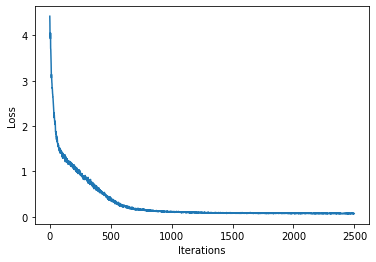

100%|██████████| 2500/2500 [49:10<00:00,  1.18s/it]


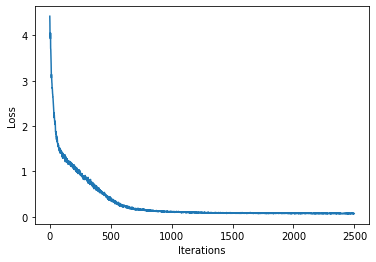

In [18]:
### Define optimizer and training operation ###

model = build_model(len(vocab), embedding_dim, rnn_units, batch_size)
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

@tf.function
def train_step(x, y): 
  with tf.GradientTape() as tape:
    y_hat = model(x)
    loss = compute_loss(y, y_hat)
  grads = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(grads, model.trainable_variables))
  return loss
##################
# Begin training!#
##################

history = []
plotter = mdl.util.PeriodicPlotter(sec=2, xlabel='Iterations', ylabel='Loss')
if hasattr(tqdm, '_instances'): tqdm._instances.clear()

for iter in tqdm(range(num_training_iterations)):

  # Grab a batch and propagate it through the network
  x_batch, y_batch = get_batch(vectorized_songs, seq_length, batch_size)
  loss = train_step(x_batch, y_batch)

  # Update the progress bar
  history.append(loss.numpy().mean())
  plotter.plot(history)

  # Update the model with the changed weights!
  if iter % 100 == 0:     
    model.save_weights(checkpoint_prefix)
    
# Save the trained model and the weights
model.save_weights(checkpoint_prefix)

In [19]:
tf.reduce_mean(loss)

<tf.Tensor: shape=(), dtype=float32, numpy=0.075867884>

In [20]:
model = build_model(len(vocab), embedding_dim, rnn_units, batch_size=1)
model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))
model.build(tf.TensorShape([1, None]))
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (1, 250, 300)             24900     
_________________________________________________________________
gru_res_block_6 (GRUResBlock (1, 250, 1024)            10371072  
_________________________________________________________________
gru_res_block_7 (GRUResBlock (1, 250, 1024)            12595200  
_________________________________________________________________
dense_3 (Dense)              (1, 250, 83)              85075     
Total params: 23,076,247
Trainable params: 23,076,247
Non-trainable params: 0
_________________________________________________________________


In [21]:
### Prediction of a generated song ###

def generate_text(model, start_string, generation_length=1000):
  input_eval = char2idx[start_string]
  input_eval = tf.expand_dims(input_eval, 0)[:, None]
  # Empty string to store our results
  text_generated = []
  model.reset_states()
  tqdm._instances.clear()

  for i in tqdm(range(generation_length)):
      predictions = model(input_eval)
      predictions = tf.squeeze(predictions, 0)
      '''TODO: use a multinomial distribution to sample'''
      predicted_id = tf.random.categorical(predictions, num_samples=1)[0, -1].numpy()
      input_eval = tf.expand_dims([predicted_id], 0)
      text_generated.append(idx2char[predicted_id])
    
  return (start_string + ''.join(text_generated))

In [22]:
'''TODO: Use the model and the function defined above to generate ABC format text of length 1000!
    As you may notice, ABC files start with "X" - this may be a good start string.'''
generated_text = generate_text(model, start_string='X', generation_length=5000)

100%|██████████| 5000/5000 [01:24<00:00, 59.32it/s]


In [24]:
generated_songs = mdl.lab1.extract_song_snippet(generated_text)

for i, song in enumerate(generated_songs): 
  # Synthesize the waveform from a song
  waveform = mdl.lab1.play_song(song) 
  if waveform:
    print("Generated song", i)
    ipythondisplay.display(waveform)

Found 24 songs in text
